In [76]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

## Creating Chill and GDD Features

Chill hours is defined as total hours per day where temperature < 7.2°C using daily min/max temperatures and a triangular approximation.

Growing Degree Days (GDD) are cumulative total of average temperatures being over the threshold, which is temperatures > 10°C.

In [77]:
full_temps_dc = pd.read_csv('Data/full_temps_dc.csv')
full_temps_dc['tavg'] = (full_temps_dc['tmin'] + full_temps_dc['tmax']) / 2
full_temps_dc['date'] = pd.to_datetime(full_temps_dc['date'])

cherry_dc = pd.read_csv("Q_blooms_dc.csv")

In [78]:
def chill_and_gdd(temp_df, bloom_df, chill_thresh = 7.2, gdd_thresh=4):
    results = []

    for year in bloom_df['year'].unique():
        bloom_doy = bloom_df.loc[bloom_df['year'] == year, 'bloom_doy'].values[0]

        # Chill Period: Oct 1 (prev year) -> Feb 28 (current year)
        chill_start = pd.Timestamp(year=year-1, month=10, day=1)
        chill_end = pd.Timestamp(year=year, month=2, day=28)

        chill_data = temp_df[
            (temp_df['date'] >= chill_start) &
            (temp_df['date'] <= chill_end)
        ].copy()

        chill_hours_tot = 0

        for _, row in chill_data.iterrows():
            tmin = row['tmin']
            tmax = row['tmax']

            if tmax < chill_thresh:
                chill_hours = 24
            elif tmin >= chill_thresh:
                chill_hours = 0
            else:
                # Partial day below threshold (Triangular approximation)
                chill_hours = 24 * (chill_thresh - tmin) / (tmax-tmin)
            chill_hours_tot += chill_hours

        # GDD until bloom
        gdd_data = temp_df[
            (temp_df['year'] == year) &
            (temp_df['doy'] <= bloom_doy)
        ]
        gdd_tot = sum(np.maximum(gdd_data['tavg']-gdd_thresh, 0))

        results.append({
            'year': year,
            'chill_hours': chill_hours_tot,
            'gdd': gdd_tot,
            'bloom_doy': bloom_doy
        })
    return pd.DataFrame(results)

model_df = chill_and_gdd(full_temps_dc, cherry_dc)

print(model_df.head())
print(model_df.describe())

   year  chill_hours     gdd  bloom_doy
0  1942  1239.408517  230.25         95
1  1943  2186.390113  245.05         94
2  1944  2111.196179  225.40        100
3  1945  2312.851436  193.05         79
4  1946  2022.637663  252.45         82
              year  chill_hours         gdd   bloom_doy
count    83.000000    83.000000   83.000000   83.000000
mean   1983.000000  1921.259383  259.212048   92.638554
std      24.103942   252.012593   44.313359    7.242453
min    1942.000000  1239.408517  164.500000   74.000000
25%    1962.500000  1773.585214  225.275000   88.000000
50%    1983.000000  1961.704061  256.050000   93.000000
75%    2003.500000  2117.483690  286.875000   97.500000
max    2024.000000  2448.101020  370.600000  108.000000


In [79]:
print(model_df.corr())
model_df.to_csv('model_df.csv')

                 year  chill_hours       gdd  bloom_doy
year         1.000000    -0.378548  0.222490  -0.371851
chill_hours -0.378548     1.000000 -0.694062   0.323713
gdd          0.222490    -0.694062  1.000000  -0.223425
bloom_doy   -0.371851     0.323713 -0.223425   1.000000


Biologcial machanism is working because gdd is negatively correlated with bloom_doy, and chill_hours has weak, positive correlation with bloom_doy. 

## Basic Model for Feature Investigation

In [80]:
X = model_df[['year','chill_hours', 'gdd']]
y = model_df['bloom_doy']

model = LinearRegression()
model.fit(X, y)

print("Intercept:", model.intercept_)
print("Coefficients:", model.coef_)
print("R^2:", model.score(X,y))

Intercept: 256.4613854543851
Coefficients: [-0.08772546  0.00572275 -0.00331052]
R^2: 0.17755404900495875


Bloom advances ~ 0.09 days per year, thus 0.9 days per decade, approximately 7-8 days ealier since 1942.
This shows an independent long-term advancement trend.

+100 chill hours -> bloom ~0.003 days later.

+10 GDD -> bloom ~ 1.08 days earlier

Heat is driving bloom timing much more than chilling. Spring heat accumulation matters most.


### With Interaction

In [81]:
model_df['interaction'] = model_df['chill_hours'] * model_df['gdd']

X = model_df[['year', 'chill_hours', 'gdd', 'interaction']]

model.fit(X,y)

print("Intercept:", model.intercept_)
print("Coefficients:", model.coef_)
print("R^2:", model.score(X,y))

Intercept: 297.67081350562415
Coefficients: [-6.66443379e-02 -3.83633713e-02 -3.27154837e-01  1.74632153e-04]
R^2: 0.2394754088560911


Chill X Heat interaction is not adding much explanatory power. Barely any improvement in R^2 from the previous model. 

### Polynomial Terms

In [82]:
model_df['gdd_sq'] = model_df['gdd'] ** 2
model_df['chill_sq'] = model_df['chill_hours'] ** 2

X = model_df[['year', 'chill_hours', 'gdd', 
              'gdd_sq', 'chill_sq'
              ]]

model.fit(X,y)

print("Intercept:", model.intercept_)
print("Coefficients:", model.coef_)
print("R^2:", model.score(X,y))

Intercept: 192.8206393479702
Coefficients: [-9.04935371e-02  7.74968610e-02  2.75774116e-02 -6.60037071e-05
 -1.92356967e-05]
R^2: 0.22447250243507821


Bloom response to heat is nonlinear; likely accelerating with higher GDD. This matches biological forcing models. 

Models for far (based on R^2):
* Biological only: 0.178
* +Year: 0.255
* +Interaction: 0.256
* +Polynomial: 0.327

## Random Forest with Cross-Val

In [83]:
model_df = pd.read_csv("model_df.csv")
X = model_df[['year', 'chill_hours', 'gdd']]
y = model_df['bloom_doy']

rf = RandomForestRegressor(
    n_estimators=500,
    max_depth=4,
    random_state=42
)

scores = cross_val_score(rf, X, y, cv=10, scoring='r2')

print("CV R^2 scores:", scores)
print("Mean CV R^2:", np.mean(scores))

CV R^2 scores: [-0.62837596  0.16723695  0.04024486 -0.03355854 -0.75708684 -0.51767646
 -0.11690226 -1.55896563  0.12851639 -0.93685602]
Mean CV R^2: -0.42134235182220925


A couple negative mean CV R2 scores meaning RandomForest model is worse than predicting the mean. Linear or polynomial regression is probably better.

## Optimizing GDD Threshold

In [84]:
candidate_thresholds = [3, 4, 4.5, 5, 6, 7]

best_thresh = None
best_rmse = np.inf

results = []

for thresh in candidate_thresholds:

    # Compute historical GDD at bloom
    def calc_gdd(year, bloom_doy):
        gdd_data = full_temps_dc[
            (full_temps_dc['year'] == year) &
            (full_temps_dc['doy'] <= bloom_doy)
        ]
        return np.sum(np.maximum(gdd_data['tavg'] - thresh, 0))

    temp_df = model_df.copy()
    temp_df['gdd'] = temp_df.apply(
        lambda r: calc_gdd(r['year'], r['bloom_doy']),
        axis=1
    )

    # Fit chill → required GDD model
    X = temp_df[['chill_hours']]
    y = temp_df['gdd']

    reg = LinearRegression()
    reg.fit(X, y)

    # Predict bloom DOY historically using threshold simulation 
    predicted_doys = []

    for _, row in temp_df.iterrows():

        year = row['year']
        chill = row['chill_hours']

        required_gdd = reg.predict([[chill]])[0]

        year_temps = full_temps_dc[
            full_temps_dc['year'] == year
        ].copy()

        year_temps['gdd'] = np.maximum(
            year_temps['tavg'] - thresh, 0
        )
        year_temps['cum_gdd'] = year_temps['gdd'].cumsum()

        pred_doy = year_temps.loc[
            year_temps['cum_gdd'] >= required_gdd
        ]['doy'].iloc[0]

        predicted_doys.append(pred_doy)

    # Evaluate DOY accuracy
    rmse = np.sqrt(
        mean_squared_error(temp_df['bloom_doy'], predicted_doys)
    )

    results.append((thresh, rmse))
    print(f"Base {thresh}°C → Bloom DOY RMSE: {rmse:.2f}")

    if rmse < best_rmse:
        best_rmse = rmse
        best_thresh = thresh


print("\nBest base temperature:")
print(f"{best_thresh}°C (RMSE = {best_rmse:.2f} days)")

/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does 

Base 3°C → Bloom DOY RMSE: 4.27
Base 4°C → Bloom DOY RMSE: 4.32
Base 4.5°C → Bloom DOY RMSE: 4.37
Base 5°C → Bloom DOY RMSE: 4.44
Base 6°C → Bloom DOY RMSE: 4.60
Base 7°C → Bloom DOY RMSE: 4.91

Best base temperature:
3°C (RMSE = 4.27 days)


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does 

Since 3°C was deemed the most optimal threshold, but most literature says 5°C is typical for Yoshino trees, we will compromise at 4°C.

## Modeling Change: GDD Threshold

Initial modeling with GDD was using cumulative GDD to predict bloom date, but that caused circular modeling, especially when trying to predict future bloom dates. Now GDD is models as a threshold:
$GDD_{crit} = a + b * Chill$ 

In [85]:
model_df= chill_and_gdd(full_temps_dc, cherry_dc)

X = model_df[['chill_hours']]
y = model_df['gdd']

gdd_model = LinearRegression()
gdd_model.fit(X,y)

print("Intercept:", gdd_model.intercept_)
print("Slope (Chill effect):", gdd_model.coef_[0])
print("R^2:", gdd_model.score(X,y))

Intercept: 493.6872107281836
Slope (Chill effect): -0.12204242938285928
R^2: 0.4817223953054214


Negative slope means more chill reduces heat requirment, which is biologically correct. Chill accumulation explaning only around 12% of variation in heat requirment. 

## Polynomial Linear Model for 2026 Predictions

### Updating DC 2026 Temperatures Data set

In [86]:
temps_2026_dc = pd.read_csv("Data/dc_Temps_2026.csv")
temps_2026_dc['date'] = pd.to_datetime(temps_2026_dc['date'])
temps_2026_dc['tavg'] = (temps_2026_dc['tmin'] + temps_2026_dc['tmax']) / 2
temps_2026_dc['year'] = 2026
temps_2026_dc['doy'] = temps_2026_dc['date'].dt.dayofyear

In [87]:
chill_thresh = 7.2

chill_start = pd.Timestamp(year=2025, month=10, day=1)
chill_end   = pd.Timestamp(year=2026, month=2, day=28)

chill_data = temps_2026_dc[
    (temps_2026_dc['date'] >= chill_start) &
    (temps_2026_dc['date'] <= chill_end)
]

chill_hours_tot = 0

for _, row in chill_data.iterrows():
    tmin = row['tmin']
    tmax = row['tmax']

    if tmax < chill_thresh:
        chill_hours = 24
    elif tmin >= chill_thresh:
        chill_hours = 0
    else:
        chill_hours = 24 * (chill_thresh - tmin) / (tmax - tmin)

    chill_hours_tot += chill_hours

print("2026 Chill Hours:", chill_hours_tot)

2026 Chill Hours: 1183.2473653639247


In [88]:
required_gdd_2026 = gdd_model.predict([[chill_hours_tot]])
print("Required GDD for 2026:", required_gdd_2026)

Required GDD for 2026: [349.2808277]


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


### 2026 Prediction

In [90]:
temps_2026_dc = temps_2026_dc.sort_values("date")

gdd_thresh = 4
cumulative_gdd = 0
predicted_date = None

for _, row in temps_2026_dc[temps_2026_dc['year'] == 2026].iterrows():
    
    gdd_day = max(row['tavg'] - gdd_thresh, 0)
    cumulative_gdd += gdd_day
    
    if cumulative_gdd >= required_gdd_2026:
        predicted_date = row['date']
        break

print("Predicted 2026 Bloom Date:", predicted_date)
print("Predicted DOY:", predicted_date.dayofyear)


Predicted 2026 Bloom Date: 2026-04-19 00:00:00
Predicted DOY: 109


This prediction is quite late, but not completely absurd. Before judging it harshly, it will be benefiical to compare the historical distribution of peak bloom dates. 

### Comparison of 2026 Prediction to Historical Distribution

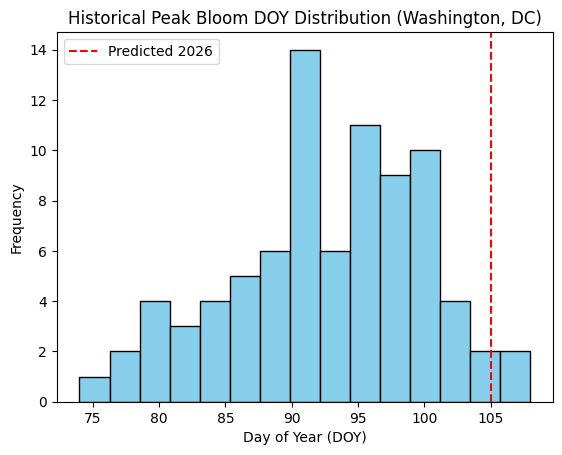

In [91]:
cherry_dc = pd.read_csv('Q_blooms_dc.csv')

historical_bloom = model_df['bloom_doy']

plt.hist(historical_bloom, bins=15, color='skyblue', edgecolor='black')
plt.axvline(105, color='red', linestyle='--', label='Predicted 2026')
plt.title("Historical Peak Bloom DOY Distribution (Washington, DC)")
plt.xlabel("Day of Year (DOY)")
plt.ylabel("Frequency")
plt.legend()
plt.show()

In [92]:
percentile = np.mean(historical_bloom <= 105) * 100
print("2026 prediction percentile:", percentile)

2026 prediction percentile: 97.59036144578313


Our 2026 prediction is in the 97th percentile which is extremely high. 

## Modeling Change: GDD Threshold with Extreme Events and Seaonal Variation Accountability 

The simple threshold model captures average relationship between chill hours and bloom timing, but ignores late frosts and spring warming variability. This new hybrid model takes into account extreme weather events in order to correct for late frosts, and accoutns for seasonal variation in spring warming. 

### Frost Risk & Spring Warming Feature Engineering

In [93]:
# Frost risk after Feb 15 within each year 
frost_flag_list = []
for year in model_df['year'].unique():
    year_data = full_temps_dc[
        (full_temps_dc['date'] >= pd.Timestamp(year=year, month=2, day=15)) &
        (full_temps_dc['date'].dt.year == year)
    ]

    severe_frost = int((year_data['tmin'] <= -4.4).any())

    frost_flag_list.append({
        'year': year,
        'severe_frost': severe_frost
    })
frost_flags = pd.DataFrame(frost_flag_list)
model_df = model_df.merge(frost_flags, on='year')

# Spring warming rate: slope of tavg across March DOY 
spring_slope_list = []
for year, grp in full_temps_dc[full_temps_dc['date'].dt.month == 3].groupby('year'):
    slope = np.polyfit(grp['doy'], grp['tavg'], 1)[0]
    spring_slope_list.append({'year': year, 'spring_slope': slope})
spring_slope = pd.DataFrame(spring_slope_list)
model_df = model_df.merge(spring_slope, on='year')

### Hypbrid Threshold Model Fit

In [94]:
# Simulate bloom DOY from threshold model for each historical year
def simulate_bloom_doy(year, required_gdd, temp_df, gdd_thresh=10):
    year_temps = temp_df[temp_df['date'].dt.year == year].sort_values('date')
    cumulative_gdd = 0
    for _, row in year_temps.iterrows():
        cumulative_gdd += max(row['tavg'] - gdd_thresh, 0)
        if cumulative_gdd >= required_gdd:
            return row['date'].dayofyear
    return np.nan  # didn't bloom in data range

# Threshold model: Required GDD ~ Chill hours
X_thresh = model_df[['chill_hours']]
y_thresh = model_df['gdd']
threshold_model = LinearRegression().fit(X_thresh, y_thresh)

# Simulate bloom DOY for each year using predicted required GDD
model_df['required_gdd_pred'] = threshold_model.predict(X_thresh)
model_df['bloom_doy_simulated'] = model_df.apply(
    lambda row: simulate_bloom_doy(row['year'], row['required_gdd_pred'], full_temps_dc),
    axis=1
)

# Residual = actual bloom DOY - simulated bloom DOY
model_df['residuals'] = model_df['bloom_doy'] - model_df['bloom_doy_simulated']

# Fit residual correction model
X_resid = model_df[['severe_frost']].dropna()
y_resid = model_df['residuals']
resid_model = LinearRegression().fit(X_resid, y_resid)

model_df['resid_pred'] = resid_model.predict(X_resid)
model_df['bloom_doy_hybrid'] = model_df['bloom_doy_simulated'] + model_df['resid_pred']

print("Hybrid model R²:", 1 - np.var(model_df['bloom_doy'] - model_df['bloom_doy_hybrid']) / np.var(model_df['bloom_doy']))

Hybrid model R²: -0.1482617990979429


### New 2026 Predictions

In [95]:
post_dorm_2026 = temps_2026_dc[
    temps_2026_dc['date'] >= pd.Timestamp(year=2026, month=2, day=15)
]

severe_frost_2026 = int((post_dorm_2026['tmin'] <= -4.4).any())

In [96]:
required_gdd_2026 = threshold_model.predict([[chill_hours_2026]])[0]

/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [97]:
cumulative_gdd = 0
predicted_doy_2026 = None

for _, row in temps_2026_dc[
    temps_2026_dc['date'].dt.year == 2026
].sort_values('date').iterrows():
    
    cumulative_gdd += max(row['tavg'] - 10, 0)
    
    if cumulative_gdd >= required_gdd_2026:
        predicted_doy_2026 = row['date'].dayofyear
        break

In [104]:
print("Required GDD:", required_gdd_2026)
print("Max cumulative GDD 2026:", cumulative_gdd)

Required GDD: 349.28082769830246
Max cumulative GDD 2026: 290.56


In [98]:
resid_corr_2026 = resid_model.predict([[severe_frost_2026]])[0]

predicted_bloom_DOY_2026 = predicted_doy_2026 + resid_corr_2026

/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


TypeError: unsupported operand type(s) for +: 'NoneType' and 'float'

### Adding Uncertainty Bands

In [99]:
historical_residuals = model_df['residuals']

lower_bound = predicted_doy_2026 + np.percentile(historical_residuals, 5)
upper_bound = predicted_doy_2026 + np.percentile(historical_residuals, 95)

TypeError: unsupported operand type(s) for +: 'NoneType' and 'float'

In [100]:
predicted_date = pd.Timestamp(year=2026, month=1, day=1) + \
                 pd.Timedelta(days=int(round(predicted_bloom_DOY_2026)) - 1)

lower_date = pd.Timestamp(year=2026, month=1, day=1) + \
             pd.Timedelta(days=int(round(lower_bound)) - 1)

upper_date = pd.Timestamp(year=2026, month=1, day=1) + \
             pd.Timedelta(days=int(round(upper_bound)) - 1)

print(f"Predicted 2026 bloom DOY: {predicted_bloom_DOY_2026:.1f}")
print(f"Predicted bloom date: {predicted_date.strftime('%B %d, %Y')}")
print(f"90% Prediction interval: {lower_date.strftime('%B %d')} – {upper_date.strftime('%B %d')}")

Predicted 2026 bloom DOY: 116.0
Predicted bloom date: April 26, 2026
90% Prediction interval: April 15 – May 07


Still a very late prediction. This could be because 2026 forecast temps are genuinely cold in March, the thershold model is overestimating requried GDD, or the Chill~GDD slope is miscalibrated. 

In [101]:
print("Chill hours 2026:", chill_hours_2026)
print("Required GDD 2026:", required_gdd_2026)
print("Threshold-only DOY:", predicted_doy_2026)

Chill hours 2026: 1183.2473653639247
Required GDD 2026: 349.28082769830246
Threshold-only DOY: None


The chill hours and required GDD look very reasonable, however the threhold-only DOY is far too high. 

### Starting GDD on March 1st instead of Jan 1st

In [ ]:
BASE_TEMP = 50  # or whatever base you used

# Filter to March 1 onward
weather_df['date'] = pd.to_datetime(weather_df['date'])
weather_df['year'] = weather_df['date'].dt.year

march_gdd = (
    weather_df[weather_df['date'].dt.month >= 3]
    .assign(
        gdd=lambda df: np.maximum(
            ((df['tmax'] + df['tmin']) / 2) - BASE_TEMP,
            0
        )
    )
    .groupby('year')['gdd']
    .cumsum()
)

weather_df.loc[weather_df['date'].dt.month >= 3, 'march_cum_gdd'] = march_gdd